<a href="https://colab.research.google.com/github/NikkiYng/EX3_NLP/blob/main/Cityname_generator_Pytorch_NN_Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline
import random
import pandas as pd

# **Data preparation**

**1. Get data from github**

In [2]:
# Chinese cities
!wget https://raw.githubusercontent.com/NikkiYng/EX3_NLP/main/china_cities.csv
cncities = pd.read_csv("china_cities.csv")
cncities = cncities['中文'].drop_duplicates() # only keep the column with city names

# Convert the `cncities` dataframe to a TXT file
with open("cncities.txt", "w") as text_file:
    cncities.to_csv(text_file, sep='\t', index=False, header=None)

cncities = open('cncities.txt', 'r').read().splitlines()
print(cncities[:30])
print(len(cncities))

--2024-03-31 18:55:02--  https://raw.githubusercontent.com/NikkiYng/EX3_NLP/main/china_cities.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.110.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 300500 (293K) [text/plain]
Saving to: ‘china_cities.csv’

china_cities.csv    100%[===================>] 293.46K  --.-KB/s    in 0.05s   

2024-03-31 18:55:02 (6.24 MB/s) - ‘china_cities.csv’ saved [300500/300500]

['北京', '海淀', '朝阳', '顺义', '怀柔', '通州', '昌平', '延庆', '丰台', '石景山', '大兴', '房山', '密云', '门头沟', '平谷', '东城', '西城', '上海', '闵行', '宝山', '黄浦', '嘉定', '浦东新区', '金山', '青浦', '松江', '奉贤', '崇明', '徐汇', '长宁']
3093


In [3]:
# American City Names
!wget https://raw.githubusercontent.com/NikkiYng/EX3_NLP/main/uscities.csv
uscities = pd.read_csv("uscities.csv")

def replace_special_chars(char): # Clean up some of the special characters
    replace = {',': '', '1': '', '2': '', '5': '', '6': '', '7': '', 'á': 'a', 'é': 'e', 'í': 'i', 'ñ': 'n', 'ó': 'o', 'ú': 'u', 'ü': 'u'}
    return replace[char] if char in replace else char

uscities = uscities['city'].map(lambda word: ''.join([replace_special_chars(char) for char in word]))
uscities = uscities.drop_duplicates()[:3093] # match the number of the cncities

# Convert the `cncities` dataframe to a TXT file
with open("uscities.txt", "w") as text_file:
    uscities.to_csv(text_file, sep='\t', index=False, header=None)

uscities = open('uscities.txt', 'r').read().lower().splitlines()
print(uscities[:30])
print(len(uscities))

--2024-03-31 18:55:02--  https://raw.githubusercontent.com/NikkiYng/EX3_NLP/main/uscities.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4703918 (4.5M) [text/plain]
Saving to: ‘uscities.csv’

uscities.csv        100%[===================>]   4.49M  --.-KB/s    in 0.1s    

2024-03-31 18:55:03 (30.5 MB/s) - ‘uscities.csv’ saved [4703918/4703918]

['new york', 'los angeles', 'chicago', 'miami', 'dallas', 'philadelphia', 'houston', 'atlanta', 'washington', 'boston', 'phoenix', 'seattle', 'san francisco', 'detroit', 'san diego', 'minneapolis', 'tampa', 'denver', 'brooklyn', 'queens', 'riverside', 'baltimore', 'las vegas', 'portland', 'san antonio', 'st. louis', 'sacramento', 'orlando', 'san jose', 'cleveland']
3093


**2. Build the vocabulary of characters and mappings to integers**

In [4]:
#American cities
chars1 = sorted(list(set(''.join(uscities))))
stoi1 = {s:i+1 for i,s in enumerate(chars1)}
stoi1['.'] = 0
itos1 = {i:s for s,i in stoi1.items()}
print(itos1)
print(len(itos1))

{1: ' ', 2: "'", 3: '-', 0: '.', 5: 'a', 6: 'b', 7: 'c', 8: 'd', 9: 'e', 10: 'f', 11: 'g', 12: 'h', 13: 'i', 14: 'j', 15: 'k', 16: 'l', 17: 'm', 18: 'n', 19: 'o', 20: 'p', 21: 'q', 22: 'r', 23: 's', 24: 't', 25: 'u', 26: 'v', 27: 'w', 28: 'x', 29: 'y', 30: 'z'}
30


In [5]:
#Chinese cities
chars2 = sorted(list(set(''.join(cncities))))
stoi2 = {s:i+1 for i,s in enumerate(chars2)}
stoi2['.'] = 0
itos2 = {i:s for s,i in stoi2.items()}
print(itos2)
print(len(itos2))

{1: '丁', 2: '七', 3: '万', 4: '丈', 5: '三', 6: '上', 7: '下', 8: '且', 9: '丘', 10: '业', 11: '丛', 12: '东', 13: '两', 14: '个', 15: '中', 16: '丰', 17: '临', 18: '丹', 19: '为', 20: '主', 21: '丽', 22: '乃', 23: '久', 24: '义', 25: '乌', 26: '乐', 27: '九', 28: '习', 29: '乡', 30: '乳', 31: '乾', 32: '二', 33: '于', 34: '云', 35: '互', 36: '五', 37: '井', 38: '亚', 39: '交', 40: '亨', 41: '京', 42: '亭', 43: '亳', 44: '什', 45: '仁', 46: '仆', 47: '介', 48: '从', 49: '仑', 50: '仓', 51: '仔', 52: '仙', 53: '代', 54: '令', 55: '仪', 56: '们', 57: '仲', 58: '任', 59: '伊', 60: '伍', 61: '休', 62: '会', 63: '伟', 64: '伦', 65: '伯', 66: '伽', 67: '余', 68: '佛', 69: '作', 70: '佳', 71: '依', 72: '侯', 73: '保', 74: '信', 75: '修', 76: '偃', 77: '偏', 78: '儋', 79: '儿', 80: '元', 81: '充', 82: '光', 83: '克', 84: '兖', 85: '全', 86: '八', 87: '公', 88: '六', 89: '兰', 90: '共', 91: '关', 92: '兴', 93: '兵', 94: '冀', 95: '内', 96: '冈', 97: '册', 98: '冕', 99: '军', 100: '农', 101: '冠', 102: '冲', 103: '冶', 104: '冷', 105: '准', 106: '凉', 107: '凌', 108: '凤', 109: '凭', 110: '凯', 111: '凰

**3. Create a three-fold dataset**

In [6]:
# American cities

# build the dataset
block_size = 7

def build_dataset(words):
  X, Y = [], []
  for w in words:

    #print(w)
    context = [0] * block_size
    for ch in w + '.':
      ix = stoi1[ch]
      X.append(context)
      Y.append(ix)
      #print(''.join(itos[i] for i in context), '--->', itos[ix])
      context = context[1:] + [ix] # crop and append

  X = torch.tensor(X)
  Y = torch.tensor(Y)
  print(X.shape, Y.shape)
  return X, Y

# prepare the data splits
random.seed(42)
random.shuffle( uscities)
n1 = int(0.8*len( uscities))
n2 = int(0.9*len( uscities))

Xtr, Ytr = build_dataset( uscities[:n1])
Xdev, Ydev = build_dataset( uscities[n1:n2])
Xte, Yte = build_dataset( uscities[n2:])

torch.Size([26005, 7]) torch.Size([26005])
torch.Size([3290, 7]) torch.Size([3290])
torch.Size([3219, 7]) torch.Size([3219])


In [7]:
# the Chinese one
block_size2 = 1 # take 1 character to predict the next one

def build_dataset_cn(words):
  X, Y = [], []
  for w in words:

    #print(w)
    context = [0] * block_size2
    for ch in w + '.':
      ix2 = stoi2[ch]
      X.append(context)
      Y.append(ix2)
      #print(''.join(itos[i] for i in context), '--->', itos[ix])
      context = context[1:] + [ix2] # crop and append

  X = torch.tensor(X)
  Y = torch.tensor(Y)
  print(X.shape, Y.shape)
  return X, Y

# prepare the data splits
random.seed(40)
random.shuffle( cncities)
n1 = int(0.8*len( cncities))
n2 = int(0.9*len( cncities))

Xtr1, Ytr1 = build_dataset_cn( cncities[:n1])
Xdev1, Ydev1 = build_dataset_cn( cncities[n1:n2])
Xte1, Yte1 = build_dataset_cn( cncities[n2:])

torch.Size([7710, 1]) torch.Size([7710])
torch.Size([960, 1]) torch.Size([960])
torch.Size([965, 1]) torch.Size([965])


#**Train the model**

**1. Set up parameters**

In [8]:
# set up the parameters
g = torch.Generator().manual_seed(2147483647) # for reproducibility
C = torch.randn((31, 10), generator=g,requires_grad=True) # 31 is the max index
W1 = torch.randn((70, 200), generator=g,requires_grad=True)
b1 = torch.randn(200, generator=g,requires_grad=True)
W2 = torch.randn((200, 31), generator=g,requires_grad=True)
b2 = torch.randn(31, generator=g,requires_grad=True) # match W2's second dimension
parameters = [C, W1, b1, W2, b2]
sum(p.nelement() for p in parameters) # number of parameters in total

20741

In [9]:
# enable gradient computation
for p in parameters:
  p.requires_grad = True

# set up learning rate
lre = torch.linspace(-3, 0, 1000) # a tensor of 1000 points evenly spaced between -3 and 0
lrs = 10**lre

# initializw lists for tracking
lri = []
lossi = []
stepi = []

**2. Train the models**

In [10]:
for i in range(200000): # iterate 200,000 times

  # minibatch construct
  ix = torch.randint(0, Xtr.shape[0], (98,))

  # forward pass
  emb = C[Xtr[ix]]
  h = torch.tanh(emb.view(-1, 70) @ W1 + b1)
  logits = h @ W2 + b2
  loss = F.cross_entropy(logits, Ytr[ix])
  #print(loss.item())

  # backward pass
  for p in parameters:
    p.grad = None
  loss.backward()

  # update
  #lr = lrs[i]
  lr = 0.1 if i < 100000 else 0.01
  for p in parameters:
    p.data += -lr * p.grad

  # track stats
  #lri.append(lre[i])
  stepi.append(i)
  lossi.append(loss.log10().item())

#print(loss.item())

**Similar steps, but for chinese**

In [11]:
# set up the parameters
g_cn = torch.Generator().manual_seed(2147483647) # for reproducibility
C_cn = torch.randn((1213, 10), generator=g_cn)
W1_cn = torch.randn((10, 200), generator=g_cn)
b1_cn = torch.randn(200, generator=g_cn)
W2_cn = torch.randn((200, 1213), generator=g_cn)
b2_cn = torch.randn(1213, generator=g_cn)
parameters_cn = [C_cn, W1_cn, b1_cn, W2_cn, b2_cn]
sum(p.nelement() for p in parameters_cn) # number of parameters in total

# enable gradient computation
for p in parameters_cn:
  p.requires_grad = True

# set up learning rate
lre_cn = torch.linspace(-3, 0, 1000) # a tensor of 1000 points evenly spaced between -3 and 0
lrs_cn = 10**lre_cn

# initializw lists for tracking
lri_cn = []
lossi_cn = []
stepi_cn = []


In [12]:

for i in range(200000):  # iterate 200,000 times
    # minibatch construct
    ix_cn = torch.randint(0, Xtr1.shape[0], (32,))

    # forward pass
    emb_cn = C_cn[Xtr1[ix_cn]]  # assuming Xtr1 is a list of indices
    h_cn = torch.tanh(emb_cn.view(-1, 10) @ W1_cn + b1_cn)
    logits_cn = h_cn @ W2_cn + b2_cn
    loss_cn = F.cross_entropy(logits_cn, Ytr1[ix_cn])

    # backward pass
    loss_cn.backward()

    # update
    lr_cn = 0.1 if i < 100000 else 0.01
    for p in parameters_cn:
        if p.grad is not None:
            p.data -= lr_cn * p.grad

    # zero out gradients for the next iteration
    for p in parameters_cn:
        p.grad = None

    # track stats
    stepi_cn.append(i)
    lossi_cn.append(loss_cn.log10().item())


# **Evaluation**

**American cities**

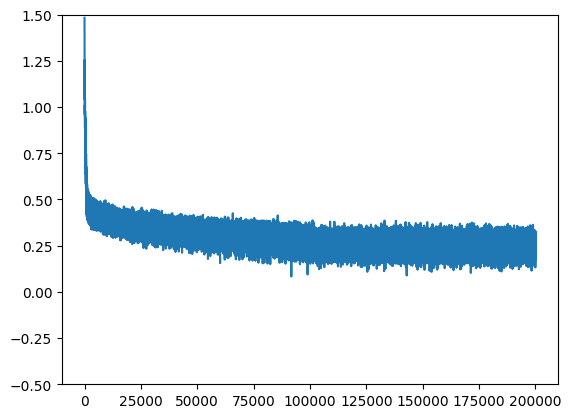

In [13]:
plt.ylim([-0.5, 1.5])  # Set the limits for y-axis
plt.plot(stepi, lossi)
plt.show()

In [14]:
# training loss
emb = C[Xtr]
h = torch.tanh(emb.view(-1, 70) @ W1 + b1)
logits = h @ W2 + b2
loss = F.cross_entropy(logits, Ytr)
loss

tensor(1.7939, grad_fn=<NllLossBackward0>)

In [15]:
# validation loss
emb = C[Xdev]
h = torch.tanh(emb.view(-1, 70) @ W1 + b1)
logits = h @ W2 + b2
loss = F.cross_entropy(logits, Ydev)
loss

tensor(2.5235, grad_fn=<NllLossBackward0>)

In [16]:
# test loss
emb = C[Xte]
h = torch.tanh(emb.view(-1, 70) @ W1 + b1)
logits = h @ W2 + b2
loss = F.cross_entropy(logits, Yte)
loss

tensor(2.4395, grad_fn=<NllLossBackward0>)

**Chinese cities**

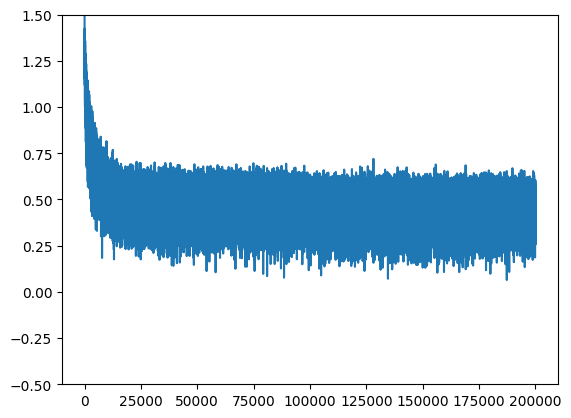

In [17]:
plt.ylim([-0.5, 1.5])  # Set the limits for y-axis
plt.plot(stepi_cn, lossi_cn)
plt.show()

In [18]:
# training loss
emb_cn = C_cn[Xtr1] # (32, 3, 2)
h_cn = torch.tanh(emb_cn.view(-1, 10) @ W1_cn + b1_cn) # (32, 100)
logits_cn = h_cn @ W2_cn + b2_cn # (32, 27)
loss_cn = F.cross_entropy(logits_cn, Ytr1)
loss_cn

tensor(2.8465, grad_fn=<NllLossBackward0>)

In [19]:
# validation loss
emb_cn = C_cn[Xdev1] # (32, 3, 2)
h_cn = torch.tanh(emb_cn.view(-1, 10) @ W1_cn + b1_cn) # (32, 100)
logits_cn = h_cn @ W2_cn + b2_cn # (32, 27)
loss_cn = F.cross_entropy(logits_cn, Ydev1)
loss_cn

tensor(10.2262, grad_fn=<NllLossBackward0>)

In [20]:
# test loss
emb_cn = C_cn[Xte1] # (32, 3, 2)
h_cn = torch.tanh(emb_cn.view(-1, 10) @ W1_cn + b1_cn) # (32, 100)
logits_cn = h_cn @ W2_cn + b2_cn # (32, 27)
loss_cn = F.cross_entropy(logits_cn, Yte1)
loss_cn

tensor(9.5669, grad_fn=<NllLossBackward0>)

# **Sample analysis**

**Generate American city names**

In [22]:
# sample from the model
g = torch.Generator().manual_seed(2147483647 + 10)

for _ in range(100):

    out = []
    context = [0] * block_size # initialize with all ...
    while True:
      emb = C[torch.tensor([context])] # (1,block_size,d)
      h = torch.tanh(emb.view(-1, 70) @ W1 + b1)
      logits = h @ W2 + b2
      probs = F.softmax(logits, dim=1)
      ix = torch.multinomial(probs, num_samples=1, generator=g).item()
      context = context[1:] + [ix]
      out.append(ix)
      if ix == 0:
        break

    print(''.join(itos1[i] for i in out))

andr city.
wouans.
lundilsville.
farcerwo.
ytann cpring.
sumlle.
alawyr park.
malpvills.
nowe.
oventville.
farney.
fasaguras.
plakburg.
sursentunsta.
adcun voighticlt.
dustor.
uunomo.
vandham.
north pram.
arkan.
linsenburg.
akadcolae.
forsond.
sadinan.
reo cete.
sallos hilly.
palmor.
marcoen city.
cortereo.
rou pass.
galliige.
torsond.
yomeage.
gerrirgton.
estarele.
kouma.
fortlton.
ewpenlel weevelork.
neveshond.
greelen.
colwy pard lendor.
wisatan.
belle.
feyswie woithe.
south ranz.
antoeros.
leedvala.
glekotville.
soulle.
plaxstoc.
manold gleveer.
beraota.
couto hao.
plameen.
parkonto.
manin.
wosshowo wast.
prowddelesville.
valleyy.
colfer.
tornase.
ettoboro.
touaktoa.
mangvieg.
grenmorisi.
rigtay cerdor.
shorele.
sumaay.
tiou.
wesdeo.
tartlamville.
corrmalni.
bolmena.
ulgkoris.
youan.
lea untap.
sdilrlhontore.
wanshan heights.
badnia.
brontving.
minorch.
cothor.
newer ciry.
jac grinde.
blaagbi.
ccpeter.
beagrade.
malla faven.
maucens.
meilen.
cor.
anrriss vidjoies.
yd.
ild ara.
zere

**Generate Chinese city names**

In [23]:
# sample from the model
g_cn = torch.Generator().manual_seed(2147483647 + 10)

for _ in range(100):

    out1 = []
    context = [0] * block_size2 # initialize with all ...
    while True:
      emb_cn = C_cn[torch.tensor([context])] # (1,block_size,d)
      h_cn = torch.tanh(emb_cn.view(-1, 10) @ W1_cn + b1_cn)
      logits_cn = h_cn @ W2_cn + b2_cn
      probs_cn = F.softmax(logits_cn, dim=1)
      ix_cn = torch.multinomial(probs_cn, num_samples=1, generator=g_cn).item()
      context = context[1:] + [ix_cn]
      out1.append(ix_cn)
      if ix_cn == 0:
        break

    print(''.join(itos2[i] for i in out1))

水.
鸡东兰溪.
乌旗.
越秀.
三水.
包头.
济.
白玉山.
通海淀.
江海口.
桦南江.
海.
索县.
崇左旗.
榆社.
新区.
汕头沟.
溆浦.
曲.
三亚东营山.
江北.
色达孜.
镇.
宁.
天全州.
龙.
凤.
铁力.
奉贤.
清.
青白水磨沟.
柳北京.
金川.
黔东海.
武义.
赞皇姑.
上街.
红原州.
崇明.
南.
龙泉驿.
湘.
三元.
定海.
安.
高陵.
黎川.
商河.
荔湾里.
兰屯.
乌旗.
雁山.
珙县.
灵石泉.
修水江.
博.
薛城.
科右后旗.
阳.
武江.
柳南阳.
青河.
天桥.
迭部.
秀屿.
濮丰.
九原.
宣汉滨江.
乌兰察右旗.
宝.
新.
天峨山.
铁岭.
习水.
安.
榆林右前郭勒.
林西.
武进贤.
渝中.
汝城.
南.
歙县.
吕梁溪.
克.
德.
延川.
长乐.
常德镇.
铜鼓楼.
翠峦.
兴义县.
铁山.
义.
泸水.
禹会.
乡.
安.
阿图什库.
桐梓.
阿里坤.
